In [2]:
print("hello world")

hello world


In [3]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import resnet50
from torchvision.ops import sigmoid_focal_loss

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [4]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

# Copier les valeurs dans un tableau modifiable
mean = np.array(mean, dtype=np.float32, copy=True)  # Copie explicite
std = np.array(std, dtype=np.float32, copy=True)

# Convertir en tenseurs PyTorch
mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


ResNet50 gets 256*256 tensors

In [5]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
transform_augmented_Flip = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=mean, std=std)
])

In [7]:
transform_data_augment_RandomRotation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=30),  
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
transform_data_augment_ColorJitter = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [9]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"]
)
train_dataset_Flip = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented_Flip,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"]
)
# train_dataset_RandomRotation = RetinaDataset(
#     root_dir='../../data/Training-Set/Training',
#     csv_file='../../data/Training-Set/Training_Labels.csv',
#     transform=transform_data_augment_RandomRotation,
#     type_of_classification='multilabel',
#     label_for_multilabel_classification=["DR", "MH", "ODC"]
# )
# train_dataset_ColorJitter = RetinaDataset(
#     root_dir='../../data/Training-Set/Training',
#     csv_file='../../data/Training-Set/Training_Labels.csv',
#     transform=transform_data_augment_ColorJitter,
#     type_of_classification='multilabel',
#     label_for_multilabel_classification=["DR", "MH", "ODC"]
# )

train_dataset_data_augment = torch.utils.data.ConcatDataset([
    train_dataset,
    train_dataset_Flip,
    # train_dataset_RandomRotation,
    # train_dataset_ColorJitter
])

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"]
)


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset_data_augment,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)


## 3. ResNet50 definition

In [11]:
# we are multiclass multilabel classification over the 3 most represented classes in the dataset 
# ("DR", "MH", "ODC" and "Normal")  for the "Normal" class, we will consider it as the absence of the 3 other classes, 
# so we will not have a specific class for it but rather the absence of all the other classes
NUMBER_OF_CLASSES = 3  

model = resnet50(weights="IMAGENET1K_V2") # https://docs.pytorch.org/vision/stable/models.html#convolutional-neural-networks 
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES) 
model = model.to(device) 

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.fc.parameters(): # last layer trainable
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\FlowUP/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s] 


In [12]:
model.share_memory

<bound method Module.share_memory of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64,

## 4. Loss definition

In [11]:
alpha = 0.25  # penalisation of minor classes
gamma = 2.0   # focusing parameter for modulating factor (1-p) to reduce the relative loss for well-classified examples, putting more focus on hard, misclassified examples
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) # equivalent to nn.BCEWithLogitsLoss() when alpha=1 and gamma=0
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## 5. Model training

In [12]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 2 

In [13]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        dataset=train_dataset,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1-score: {train_f1:.4f} | Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test F1-score: {test_f1:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Used GPU VRAM: {torch.cuda.memory_allocated() / 1024**3:.2f} Go")

    
    # Early stopping
    scheduler.step(test_loss)  # Met à jour le scheduler en fonction de la perte de test
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)
    torch.cuda.empty_cache()
    print("="*70)


Epoch number: 0


100%|██████████| 56/56 [00:02<00:00, 23.55it/s]


Train Loss: 0.0491 | Train Accuracy: 0.5446 | Train F1-score: 0.0191 | Train ROC-AUC: 0.5005
Test Loss: 0.0461 | Test Accuracy: 0.5365 | Test F1-score: 0.0000 | Test ROC-AUC: 0.5000
Mémoire GPU utilisée: 0.10 Go
Epoch number: 1


100%|██████████| 56/56 [00:01<00:00, 30.97it/s]


Train Loss: 0.0444 | Train Accuracy: 0.5569 | Train F1-score: 0.0000 | Train ROC-AUC: 0.5000
Test Loss: 0.0456 | Test Accuracy: 0.5365 | Test F1-score: 0.0000 | Test ROC-AUC: 0.5000
Mémoire GPU utilisée: 0.10 Go


In [15]:
torch.save(model.state_dict(), '../Models/model_ft_resnet50_mcmlc.pth')

In [16]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_resnet50_mcmlc.csv', index=False)

## 6. Evolution of the training

In [ ]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_resnet50_mcmlc.csv')

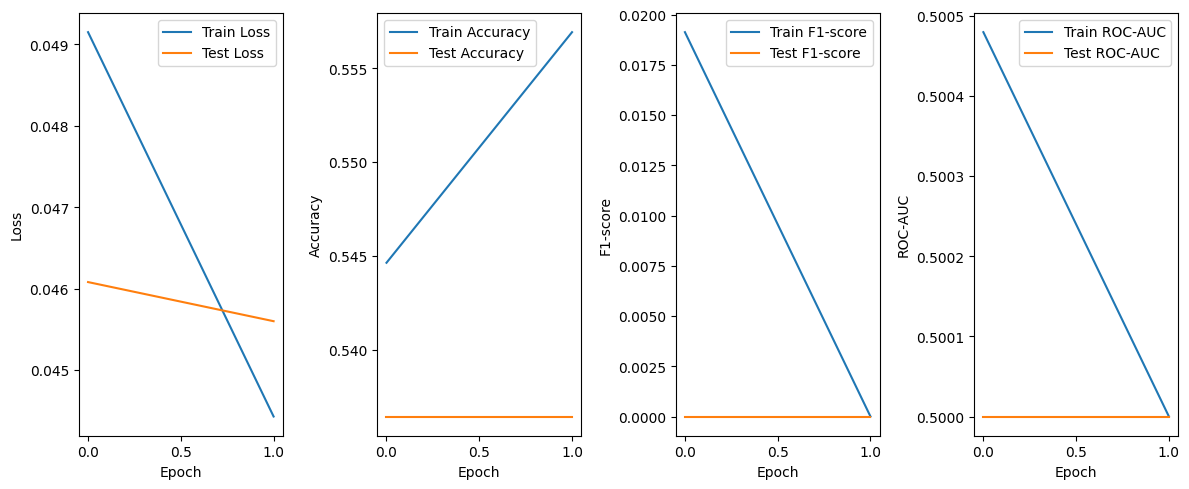

In [18]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_mcmlc_zoomed.png',
    title='Training Evolution - Fine Tuned ResNet50 Multi-Class Multi-Labeling Zoomed',
    zoomed=True
)


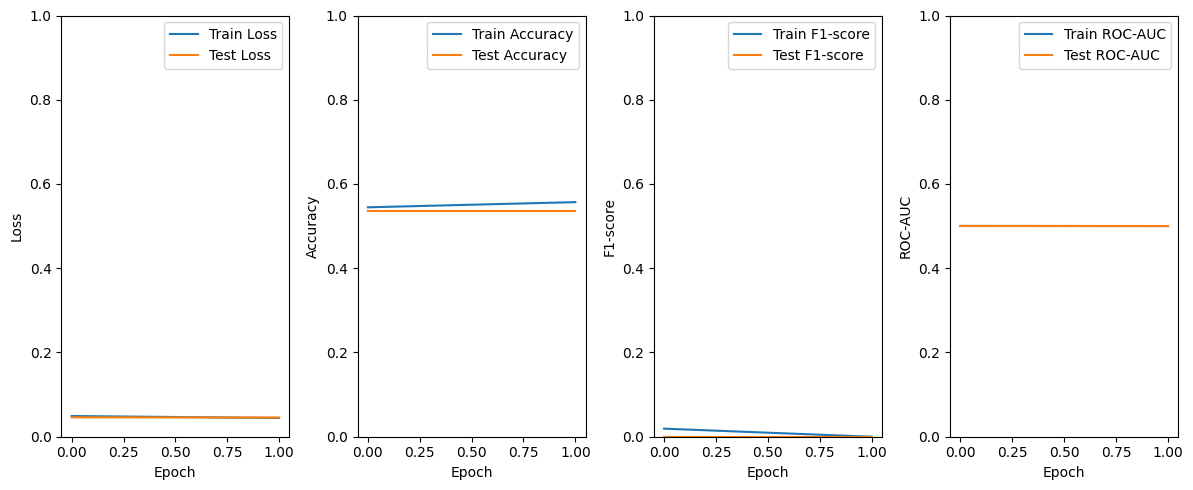

In [19]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_mcmlc.png',
    title='Training Evolution - Fine Tuned ResNet50 Multi-Class Multi-Labeling',
    zoomed=False
)


## 7. Model evaluation

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUMBER_OF_CLASSES = 3  

model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_resnet50_mcmlc.pth', weights_only=True))
alpha = 0.25  
gamma = 2.0   
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) 

c:\Users\FlowUP\Documents\Projets\Eye-Disease-Classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\FlowUP\Documents\Projets\Eye-Disease-Classifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device)

In [25]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.0424 | Validation Accuracy: 0.5828 | Validation F1-score: 0.0000 | Validation ROC-AUC: 0.5000
